# Import software libraries and load the dataset #

In [1]:
import sys                             # Read system parameters.
import os                              # Interact with the operating system.
import numpy as np                     # Work with multi-dimensional arrays and matrices.
import pandas as pd                    # Manipulate and analyze data.
import matplotlib                      # Create 2D charts.
import matplotlib.pyplot as plt
import seaborn as sb                   # Perform data visualization.
import sklearn                         # Perform data mining and analysis.
from time import time                  # Calculate training time.

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Seaborn {}'.format(sb.__version__))
print('- scikit-learn {}\n'.format(sklearn.__version__))

# Load the dataset.
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "titanic_data")
print('Data files in this project:', os.listdir(DATA_PATH))
data_raw_file = os.path.join(DATA_PATH, 'train.csv')
data_raw = pd.read_csv(data_raw_file)
print('Loaded {} records from {}.'.format(len(data_raw), data_raw_file))

Libraries used in this project:
- Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
- NumPy 1.16.2
- pandas 0.24.2
- Matplotlib 3.0.3
- Seaborn 0.9.0
- scikit-learn 0.20.3

Data files in this project: ['train.csv', 'test.csv']
Loaded 891 records from ./titanic_data/train.csv.


# Split the datasets

In [2]:
# Separate training and test sets already exist.
# A validation set will be split off from the training sets.

from sklearn.model_selection import train_test_split

# 'Survived' is the dependent variable (value to be predicted), so it will be
# removed from the training data and put into a separate DataFrame for labels.
label_columns = ['Survived']

training_columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

# Split the training and validation datasets and their labels.
X_train, X_val, y_train, y_val = train_test_split(data_raw[training_columns],
                                                                            data_raw[label_columns],
                                                                            random_state = 1912)
print('The training and validation datasets and labels have been split.')

The training and validation datasets and labels have been split.


# Perform common preparation on the training and validation sets

In [3]:
# Perform common cleaning and feature engineering tasks on datasets.
def prep_dataset(dataset):
    
    # PROVIDE MISSING VALUES
    
    # Fill missing Age values with the median age.
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    # Fill missing Fare values with the median fare.
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

    # Fill missing Embarked values with the mode.
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    
    # FEATURE ENGINEERING
    
    # Size of family and whether passenger is traveling alone.
    size_of_family = dataset['SibSp'] + dataset['Parch'] + 1        
    dataset['SizeOfFamily'] = size_of_family
        
    # Extract the title from the passenger's name.
    title = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['Title'] = title
    
    
    # CONVERT CATEGORICAL VALUES TO NUMERIC ENCODINGS
    
    title_encode = {}
    count = 1
    for i in title.unique():
        title_encode.update({i: count})
        count += 1
    
    sex_encode = {'female': 1, 'male': 2}
    
    embarked_encode = {'S':1, 'C':2, 'Q':3}
    
    dataset['SexEncoding'] = dataset['Sex'].map(sex_encode)
    dataset['EmbarkedEncoding'] = dataset['Embarked'].map(embarked_encode)
    
    dataset['TitleEncoding'] = dataset['Title'].map(title_encode)
    dataset['TitleEncoding'].fillna(dataset['TitleEncoding'].mode()[0], inplace = True)

    return dataset

X_train = prep_dataset(X_train.copy())

X_val = prep_dataset(X_val.copy())

print('The training and validation datasets have been cleaned and prepared.')

The training and validation datasets have been cleaned and prepared.


# Drop columns that won't be used for training

In [4]:
# Drop unused columns from datasets.
def drop_unused(dataset):
        
    dataset = dataset.drop(['PassengerId'], axis=1)
    dataset = dataset.drop(['Cabin'], axis=1)
    dataset = dataset.drop(['Ticket'], axis=1)
    dataset = dataset.drop(['Name'], axis=1)

    # These have been replaced with numeric codes.
    dataset = dataset.drop(['Title'], axis=1)
    dataset = dataset.drop(['Sex'], axis=1)
    dataset = dataset.drop(['Embarked'], axis=1)
    
    return dataset

X_train = drop_unused(X_train.copy())

X_val = drop_unused(X_val.copy())

print('The unused columns have been dropped.')

The unused columns have been dropped.


# Create a logistic regression model

In [5]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='sag', C = 0.05, max_iter = 10000)
start = time()
log_reg.fit(X_train, np.ravel(y_train))
end = time()
train_time = (end - start) * 1000

prediction = log_reg.predict(X_val)

# Score using the validation data.
score = log_reg.score(X_val, y_val)

print('Score on validation set: {:.0f}%'.format(score * 100))

Score on validation set: 78%


# Identify the class distribution in the dataset

Perished (Class 0): 549
Survived (Class 1): 342


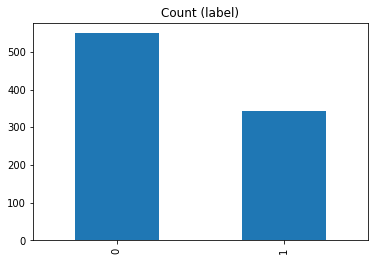

In [6]:
label_count = data_raw['Survived'].value_counts()
print('Perished (Class 0):', label_count[0])
print('Survived (Class 1):', label_count[1])

label_count.plot(kind = 'bar', title = 'Count (label)');

# Generate a confusion matrix

In [7]:
from sklearn.metrics import confusion_matrix

def c_matrix_graph(y, prediction):
    c_matrix = confusion_matrix(y, prediction)
    
    ax = plt.subplot()

    sb.set(font_scale = 1.2)
    sb.heatmap(c_matrix, annot = True, fmt = 'g', ax = ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction', fontsize = 18);
    ax.set_ylabel('Actual', fontsize = 18);
    ax.xaxis.set_ticklabels(['perished (0)', 'survived (1)'], fontsize = 12, va = 'center');
    ax.yaxis.set_ticklabels(['perished (0)', 'survived (1)'], fontsize = 12, va = 'center');
    
print('The confusion matrix graphing function has been defined.')

The confusion matrix graphing function has been defined.


# Compute accuracy, precision, recall, and F<sub>1</sub> score

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def model_scores(y, prediction):
    acc = accuracy_score(y, prediction)
    print('Accuracy: {:.0f}%'.format(np.round(acc * 100)))
    
    precision = precision_score(y, prediction)
    print('Precision: {:.0f}%'.format(np.round(precision * 100)))
    
    recall = recall_score(y, prediction)
    print('Recall: {:.0f}%'.format(np.round(recall * 100)))
    
    f1 = f1_score(y, prediction)
    print('F1: {:.0f}%'.format(np.round(f1 * 100)))
    
print('The function to compute scores has been defined.')

The function to compute scores has been defined.


# Generate a ROC curve and compute the AUC

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def roc(y, prediction_proba):
    fpr, tpr, thresholds = roc_curve(y, prediction_proba)
    
    plt.plot(fpr, tpr);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('ROC Curve');
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.grid(True);
    
    auc = roc_auc_score(y, prediction_proba)
    print('Area Under Curve: {:.2f}'.format(auc))
    
print('The function to generate a ROC curve and compute AUC has been defined.')

The function to generate a ROC curve and compute AUC has been defined.


# Generate a precision–recall curve and compute the average precision

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def prc(y, prediction_proba):
    precision, recall, thresholds = precision_recall_curve(y, prediction_proba)
    
    plt.plot(recall, precision);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('Precision–Recall Curve');
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.grid(True);
    
    ap = average_precision_score(y, prediction_proba)
    print('Average Precision: {:.2f}'.format(ap))
    
print('The function to generate a precision-recall curve and compute average precision has been defined.')

The function to generate a precision-recall curve and compute average precision has been defined.


# Evaluate the initial logistic regression model

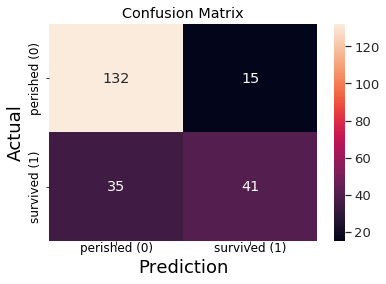

In [11]:
initial_predict = log_reg.predict(X_val)

c_matrix_graph(y_val, initial_predict)

In [12]:
model_scores(y_val, initial_predict)

Accuracy: 78%
Precision: 73%
Recall: 54%
F1: 62%


Area Under Curve: 0.85


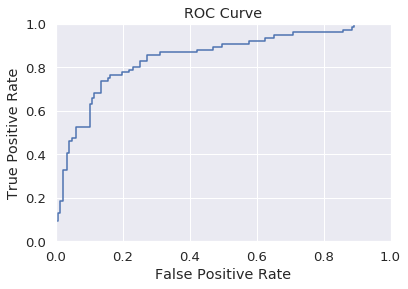

In [13]:
initial_predict_proba = log_reg.predict_proba(X_val)

roc(y_val, initial_predict_proba[:, 1])

Average Precision: 0.76


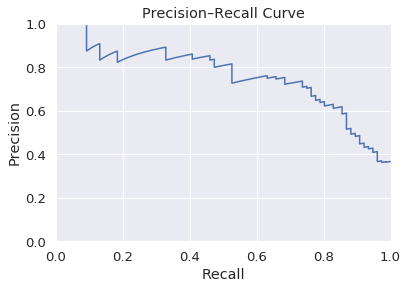

In [14]:
prc(y_val, initial_predict_proba[:, 1])

# Fit a logistic regression model using grid search with cross-validation

In [15]:
from sklearn.model_selection import GridSearchCV

grid = [{'solver': ['liblinear'],
         'penalty': ['l1', 'l2'],
         'C': [0.001, 0.01, 0.1, 1, 5, 10, 25, 50, 100]},
        {'solver': ['sag'],
         'penalty': ['l2'],
         'C': [0.001, 0.01, 0.1, 1, 5, 10, 25, 50, 100],
         'max_iter': [10000]}]

search = GridSearchCV(log_reg, param_grid = grid, scoring = 'f1', cv = 5, iid = False)
search.fit(X_train, np.ravel(y_train));

print(search.best_params_)

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


# Evaluate the optimized model

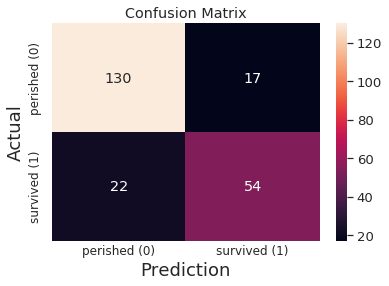

In [16]:
search_predict = search.predict(X_val)

c_matrix_graph(y_val, search_predict)

In [17]:
model_scores(y_val, search_predict)

Accuracy: 83%
Precision: 76%
Recall: 71%
F1: 73%


Area Under Curve: 0.85


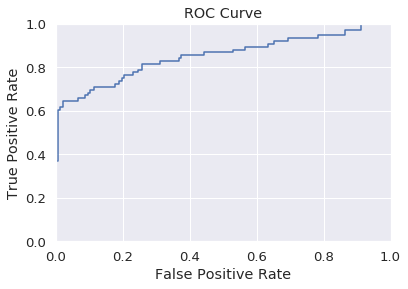

In [18]:
search_predict_proba = search.predict_proba(X_val)

roc(y_val, search_predict_proba[:, 1])

Average Precision: 0.84


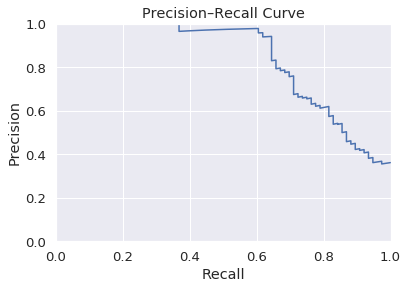

In [19]:
prc(y_val, search_predict_proba[:, 1])

# Compare the logistic regression models' predictions on the test data

In [20]:
# Read the test dataset.
X_test_file = os.path.join(DATA_PATH, 'test.csv')
X_test_raw = pd.read_csv(X_test_file)
print('Loaded {} records from {}\n'.format(len(X_test_raw), X_test_file))

X_test = prep_dataset(X_test_raw.copy())
X_test = drop_unused(X_test.copy())

Loaded 418 records from ./titanic_data/test.csv



In [21]:
# Show example predictions with the test data using the initial (unoptimized) model.
results_log_reg = X_test_raw.copy()
results_log_reg['PredictedSurvival'] = log_reg.predict(X_test)
results_log_reg['ProbPerished'] = np.round(log_reg.predict_proba(X_test)[:, 0] * 100, 2)
results_log_reg['ProbSurvived'] = np.round(log_reg.predict_proba(X_test)[:, 1] * 100, 2)
results_log_reg.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PredictedSurvival,ProbPerished,ProbSurvived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,74.29,25.71
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,68.02,31.98
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,70.70,29.30
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,82.30,17.70
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,66.31,33.69
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,81.58,18.42
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1,36.70,63.30
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,80.96,19.04
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0,51.48,48.52
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,88.19,11.81


In [22]:
# Show example predictions with the test data using the model optimized with grid search.
results_log_reg = X_test_raw.copy()
results_log_reg['PredictedSurvival'] = search.predict(X_test)
results_log_reg['ProbPerished'] = np.round(search.predict_proba(X_test)[:, 0] * 100, 2)
results_log_reg['ProbSurvived'] = np.round(search.predict_proba(X_test)[:, 1] * 100, 2)
results_log_reg.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PredictedSurvival,ProbPerished,ProbSurvived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,89.31,10.69
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,65.92,34.08
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,87.97,12.03
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,90.35,9.65
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,47.80,52.20
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,85.35,14.65
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1,28.59,71.41
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,83.01,16.99
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1,27.28,72.72
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,94.06,5.94
